# Scientific Data in Python: From Acquisition to Publication

Written by Patrick Tapping 2021, and free to use under a [Creative Commons CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) licence.

In this notebook, you will be using your computer's sound card and microphone to acquire some data, analyse it, and plot the results.

The `sounddevice` python package is required for audio capture and playback.
See the [documentation](https://python-sounddevice.readthedocs.io/en/latest/installation.html) for installation instructions.
Typically, this will be by running the command `python3 -m pip install sounddevice` in your operating system's terminal.
For Anaconda python distributions this will be `conda install -c conda-forge python-sounddevice`.

We will also do some curve fitting using the `lmfit` library.
It should be [installed](https://lmfit.github.io/lmfit-py/installation.html) in a similar manner, for example `python3 -m pip install lmfit` or `conda install -c conda-forge lmfit`.
If possible, also install the `emcee` and `tqdm` packages, which will allow for improved error estimations for the fits (eg. using `python3 -m pip install lmfit emcee tqdm`).

In [1]:
import time

import numpy as np
from scipy.io import wavfile
from scipy.signal import welch, spectrogram
from scipy.linalg import svd
from scipy.fft import irfft
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.ticker import IndexLocator
from matplotlib.offsetbox import AnchoredText
import sounddevice as sd
import lmfit

# Use white background instead of transparent on saved figures
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

# To ignore any warning messages in cell ouput
import warnings
warnings.simplefilter("ignore")

# Widget is for newer Jupyter Lab, uncomment if using jupyter lab
# %matplotlib widget

## Acquiring Some Data

Next, we're going to record some audio data from your microphone. The best results should be achieved by recording something with a good resonance at higher frequencies, for example a bell, note from a musical instrument, or by singing an "ohhh".
Later, you may want to come back here and try recording something more complicated.

If for some reason recording doesn't work, skip down to the cell below where you can load some data from a file instead. Note that if you are running this notebook on a remote computer (eg. a Google Colab instance), the audio will be recorded from the remote machine and not the client running the web browser! In that case, skip below to use a pre-recorded sample.

In [2]:
# Options for Recording #######################################################

# Sampling frequency, in Hz
# 48 kHz is a typical default for most sound devics, 96 kHz is a typical maximum
# Try 44100 if that doesn't work for some reason
fs = 48000

# Duration of audio clip to record, in s
duration = 8.0

###############################################################################

# Give a countdown before recording. [::-1] reverses an array.
for i in np.arange(1, 4)[::-1]:
    print(f"{i}...", end="")
    time.sleep(0.5)
print("Recording!")

# Capture some audio
data_raw = sd.rec(frames=int(duration*fs), samplerate=fs, blocking=True, channels=1)

# The returned data is a multidimensional array (since it can potentially contain stereo audio etc)
print(f"Acquired a {data_raw.shape} array of {data_raw.dtype} ({data_raw.nbytes} bytes)")
# We'll just pull out the first (only) audio channel to process
data_raw = data_raw[:,0]

3...2...1...Recording!
Acquired a (384000, 1) array of float32 (1536000 bytes)


### Loading Pre-recorded Data

If recording didn't work, or you want to try a pre-made example, then run this next cell to load some audio data from a file. Note that it will wipe anything you recorded yourself above!

In [3]:
# If recording didn't work, or you want to try a pre-made example, then
# run this cell to load some audio data from a file.
#fs, wav = wavfile.read("kalimba-resonance.wav")
fs, wav = wavfile.read("ukulele-c-chord.wav")
#fs, wav = wavfile.read("ukulele-f-chord.wav")

# Normalise the data to match dynamic range returned from sounddevice recordings
data_raw = wav/np.abs(wav).max()

## Data Analysis and Manipulation

Next, we'll start to explore the data we have acquired. We'll clean it up, and see what interesting things we can visualise from it.

In [4]:
# Play back the audio clip to see what the raw data is like
sd.play(data_raw, samplerate=fs)

In [5]:
# Generate raw data time axis labels
t = np.arange(0.0, data_raw.shape[0]/fs, 1.0/fs)

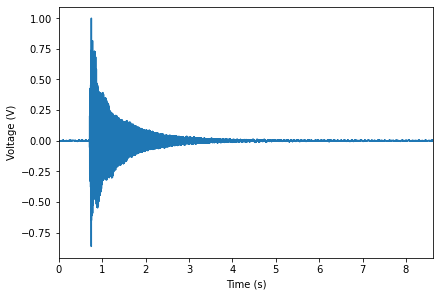

In [6]:
# Plot out the raw wave data
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)

# Wave data
ax.plot(t, data_raw)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (V)")
ax.set_xlim(t[0], t[-1])

fig.show()

### Cleaning Up

We will trim the data down and correct for time-zero by shifting the time axes.
Time-zero should be when the impulse first begins.
On jupyterlab widget or jupyter notebook type plots, you can zoom into the plot to find this using the four-headed arrow tool and dragging with the right mouse button.

In [7]:
# Options for Cropping and Time-zero Correction ###############################

# If you would like to trim off excess data, select the crop range here
# Zoom into plot if that helps
# Use "None" to indicate the very start or end of the data
crop_t = (None, None)

# Time when impulse first begins, which we want to be time zero
# Zoom into plot to get an accurate value for this
t0 = 0.707

###############################################################################

# Crop data down to selected range
# We need to find the array index closest to the selected time values
crop_lo = np.argmin(np.abs(t - crop_t[0])) if not crop_t[0] is None else None
crop_hi = np.argmin(np.abs(t - crop_t[1])) if not crop_t[1] is None else None
t = t[crop_lo:crop_hi]
data_raw = data_raw[crop_lo:crop_hi]

# Shift the time axis for the raw data 
t -= t0

You can run the plotting cell above to check that the crop and time-zero correction did what you expected.

### Frequency Analysis

The raw data can be considered as the voltage measured by the analogue-to-digital converter in your computer's sound card.
This in turn relates to the sound pressure waves incident on the microphone diaphragm.
We'd like to do some spectroscopy, so we will use Fourier transform techniques so that we can view our data in the frequency domain.
This method of direct detection of the waveform and the subsequent Fourier transform is actually how some spectroscopic techniques are performed.
For example, in terahertz spectroscopy, the magnitude of the oscillating electric field is measured by the detector.

We'll start by doing frequency analysis using [Welch's method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html).

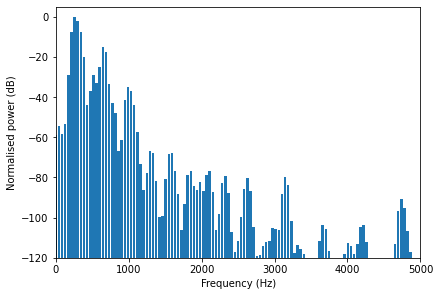

In [8]:
# Options for Frequency Analysis ##############################################

# Size of Fourier transform blocks, in audio samples
# Larger values will give better low-frequency resolution, but at the expense of temporal resolution
fft_size = 1024

# Zoom plots into a particular frequency range of interest
freq_range = (0, 5000)

###############################################################################

# Compute power spectral density using Welch's method, plus frequency axis labels
freqs_f, freqs = welch(data_raw, fs=fs, nperseg=fft_size, window="blackmanharris")
# Convert units to a normalised decibel (logarithmic) scale commonly used for audio measurements
freqs_db = 20*np.log10(freqs/freqs.max())

# Plot out the frequency spectrum
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)

# Spectrum data, as bar chart, so we can see frequency resolution clearly
ax.bar(freqs_f, 120 + freqs_db, width=0.8*(freqs_f[1] - freqs_f[0]), bottom=-120)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Normalised power (dB)")
ax.set_xlim(freq_range)
ax.set_ylim(-120, 5)

fig.show()

We can now see the dominant frequencies present in the data, but have lost all of the temporal resolution.
It would be nice if we could see how the frequencies evolve over time.
This is possible, but requires a compromise between the temporal and spectral resolution.
The [spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) effectively cuts the raw data up into small segments and performs frequency analysis on each segment.

Spectrogram shape is (513, 424)


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


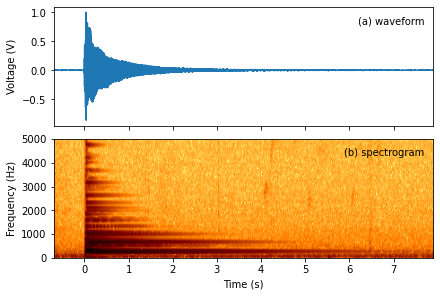

In [9]:
# Generate spectrogram, plus its frequency and time axis labels
spec_f, spec_t, spec = spectrogram(data_raw, fs=fs, nperseg=fft_size, window="blackmanharris")
# Convert to decibel scale
spec_db = 20*np.log10(spec/spec.max())
print(f"Spectrogram shape is {spec.shape}")

# The spectrogram will also need a time-zero correction to match the raw data
spec_t -= t0 - (crop_t[0] if crop_t[0] else 0.0)

# Plot out the raw wave data, and the generated spectrogram
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

# Upper wave data panel
ax1.plot(t, data_raw)
ax1.set_ylabel("Voltage (V)")
ax1.add_artist(AnchoredText("(a) waveform", loc="upper right", frameon=False))

# Lower spectrogram panel
ax2.imshow(spec_db, origin="lower", aspect="auto", extent=(spec_t[0], spec_t[-1], spec_f[0], spec_f[-1]), cmap="afmhot_r", rasterized=True)
ax2.set_ylim(freq_range)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
ax2.add_artist(AnchoredText("(b) spectrogram", loc="upper right", frameon=False))

fig.align_labels()
fig.show()
fig.savefig("wave_plus_spectrogram.pdf")

### Background Removal

There may be some background noise in the data that is not part of the signal of interest. These unwanted components would be evident both before time-zero, and at late times after the main signal has decayed. If the noise is constant throughout the data, and has distinct frequency characteristics, then we can attempt to remove it.

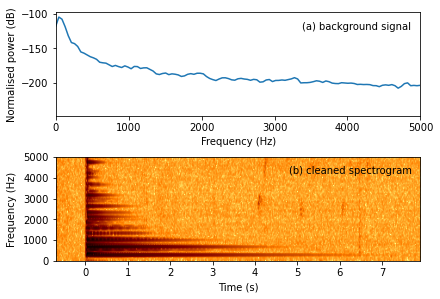

In [10]:
# First, sample the unwanted background frequency spectrum from the data before time-zero
background = np.mean(spec_db[:,spec_t < 0.0], axis=1)
# Now subtract it from the entire data set
spec_db -= background[:,np.newaxis]
# Maintain normalisation
spec_db -= spec_db.max()

# Plot out the background spectrum and the cleaned spectrogram
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, (ax1, ax2) = plt.subplots(2, 1,constrained_layout=True)

# Upper background spectrum panel
ax1.plot(spec_f, background)
ax1.set_xlim(freq_range)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Normalised power (dB)")
ax1.add_artist(AnchoredText("(a) background signal", loc="upper right", frameon=False))

# Lower cleaned spectrogram panelFigure 108

ax2.imshow(spec_db, origin="lower", aspect="auto", extent=(spec_t[0], spec_t[-1], spec_f[0], spec_f[-1]), cmap="afmhot_r", rasterized=True)
ax2.set_ylim(freq_range)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
ax2.add_artist(AnchoredText("(b) cleaned spectrogram", loc="upper right", frameon=False))

fig.align_labels()
fig.show()


### Spectral and Temporal Slices

By taking slices through the spectrogram in either the horizontal or vertical directions, we can obtain spectral and temporal slices.
A spectral slice shows the spectrum at some particular time, while the temporal slice shows the decay kinetics of a selected frequency.

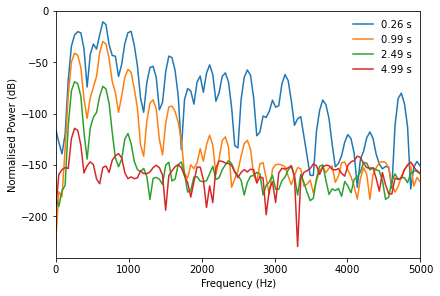

In [11]:
# Options for Spectral Slice Plots ############################################

# Select times for plotting out spectral slices from the spectrogram
times = [0.25, 1.0, 2.5, 5.0]

###############################################################################

# Plot the spectra at the selected time points
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)

for time_value in times:
    # Find array index closest to the selected time
    t_i = np.argmin(np.abs(spec_t - time_value))
    ax.plot(spec_f, spec_db[:,t_i], label=f"{spec_t[t_i]:.2f} s")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Normalised Power (dB)")
ax.set_xlim(freq_range)
ax.legend(loc="best", frameon=False)

fig.show()

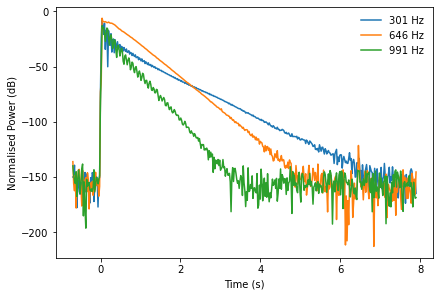

In [12]:
# Options for Temporal Slice Plots ############################################

# Select frequencies for plotting out kinetics from the spectrogram
frequencies = [286, 657, 1000]

###############################################################################

# Plot the kinetics at the selected frequencies
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)

for frequency in frequencies:
    # Find array index closest to the selected frequency
    f_i = np.argmin(np.abs(spec_f - frequency))
    ax.plot(spec_t, spec_db[f_i,:], label=f"{spec_f[f_i]:.0f} Hz")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalised Power (dB)")
ax.legend(loc="best", frameon=False)

fig.show()

## Curve Fitting

We will use the [lmfit package](https://lmfit.github.io/lmfit-py/index.html) to do some fitting to the kinetic traces.
This is an excellent package which interfaces into a number of optimisation library backends.
It allows a consistent way of managing parameters, including bounding or fixing them, even if not supported by the backend.
The optimisation method can be then changed without having to restructure large amounts of code.

The first task is to consider what functional form will fit the data, and build a set of parameters which will be used to describe it.
For this audio data, remember we are working with a logarithmic power scale, so a first-order exponential decay will have a linear shape.
We will base our function around a linear equation $A(t) = A_0 -kt$, but there is also the "silence" present before time zero, which is actually the noise floor into which the signal eventually decays.

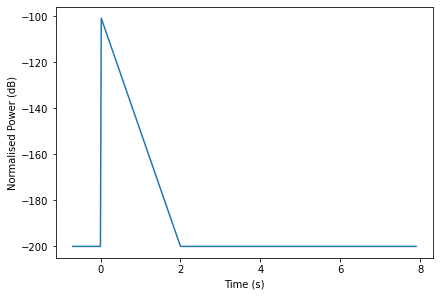

In [13]:
# Create a set of parameters to use for the fitting
params = lmfit.Parameters()
params.add("A_bg", value=-200.0, min=-300.0, max=-50.0, vary=False)  # Background signal amplitiude (dB)
params.add("t_0", value=0.0, min=-0.25, max=0.25, vary=True)         # Time zero (s)
params.add("A_0", value=100.0, min=-50.0, max=300.0, vary=True)      # Amplitude of signal (dB)
params.add("k", value=50.0, min=1.0, max=1000.0, vary=True)          # Rate of signal decay (dB per s)


# Functional form of the fit
def fit_function(params, x):
    """
    Function used to model the data.
    
    :param params: The `lmfit.Parameters` to use for the function.
    :param x: Coordinates at which to evaluate the function.
    :returns: Value of the function at the given x coordinates.
    """
    # Just grab the parameter values
    p = params.valuesdict()
    # Calculate the function
    result = p["A_0"] - p["k"]*(x - p["t_0"]) + p["A_bg"]
    # Signal should be zero (only background) before time-zero
    result[x < p["t_0"]] = p["A_bg"]
    # Signal should vanish into the background noise once it has decayed
    result[result < p["A_bg"]] = p["A_bg"]
    return result


# Plot the function to see if it has the shape we are expecting
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(spec_t, fit_function(params, spec_t))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalised Power (dB)")
fig.show()

Once we are confident the function has the right shape to fit the data, we can make a function to calculate the residuals, which the fitting routine will try to minimise.
The array of residuals will generally just be the difference between the model and the experimental data.

In [14]:
def residuals(params, x, exp_data):
    """
    Calculate the difference between the experimental data and the model using the given parameters.
    
    :param params: The `lmfit.Parameters` to use for the function.
    :param x: Coordinates at which to evaluate the function.
    :exp_data: Experimental data at the given x coordinates.
    :returns: Array of residuals.
    """
    # The level of the background noise can be taken from the data itself, before time-zero
    # Note we had set vary=False, so this parameter is not actually being fitted
    params["A_bg"].set(np.mean(exp_data[x < params["t_0"].value]))
    return fit_function(params, x) - exp_data

--------------------------------------------------------------------------------
Performing initial fit for 301 Hz:
[[Variables]]
    A_bg: -154.6127 (fixed)
    t_0:   6.0848e-04 (init = 0)
    A_0:   129.913499 (init = 100)
    k:     18.2632702 (init = 50)
Estimating errors from leastsq covariance matrix:
[[Variables]]
    A_bg: -154.6127 (fixed)
    t_0:  -0.00325427 +/- 445.028093 (13675191.89%) (init = 0.0006084779)
    A_0:   129.985231 +/- 8128.37995 (6253.31%) (init = 129.9135)
    k:     18.2634470 +/- 0.19173715 (1.05%) (init = 18.26327)
        68.27%    _BEST_    68.27%
 t_0:      -inf  -0.00325      +inf
 A_0:  -0.87125 129.98523  +6.37959
 k  :      -inf  18.26345      +inf
--------------------------------------------------------------------------------
Performing initial fit for 646 Hz:
[[Variables]]
    A_bg: -154.6127 (fixed)
    t_0:  -0.00106186 (init = 0)
    A_0:   152.309455 (init = 100)
    k:     29.1420886 (init = 50)
Estimating errors from leastsq covariance 

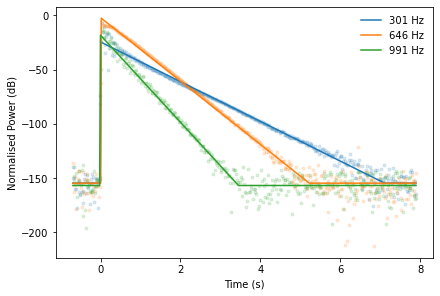

In [15]:
#### Options for Fitting #########################################################

# Select frequencies for plotting out kinetics from the spectrogram
# Comment out to use same frequencies as kinetic plot above
# frequencies = [370, 825, 4650]

# Use emcee method for determining errors in fit (slow, good)
# Otherwise the covariance matrix of a least-squares fit will be used (fast, poor)
use_emcee = False

###############################################################################

# Store the results of the fits in a list
fits = []

# Plot the kinetics at the selected frequencies
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig, ax = plt.subplots(constrained_layout=True)

for frequency in frequencies:
    
    # Find array index closest to the selected frequency
    f_i = np.argmin(np.abs(spec_f - frequency))
    
    # Plot the selected kinetic trace
    ax.scatter(spec_t, spec_db[f_i,:], alpha=0.15, marker=".")
    
    # Run the minimiser on the residuals function using the selected kinetic slice
    print(f"{80*'-'}\nPerforming initial fit for {spec_f[f_i]:.0f} Hz:")
    minner = lmfit.Minimizer(residuals, params, fcn_args=(spec_t, spec_db[f_i,:]))
    minresult = minner.minimize(method="nelder")
    lmfit.report_fit(minresult.params, show_correl=False)
    
    # Estimate errors in fitting parameters
    if use_emcee:
        print("Estimating errors by emcee method:")
        minresult = minner.emcee(params=minresult.params)
        lmfit.report_fit(minresult.params, show_correl=False)
    else:
        print("Estimating errors from leastsq covariance matrix:")
        minresult = minner.minimize(method='leastsq', params=minresult.params)
        lmfit.report_fit(minresult.params, show_correl=False)
        minci = lmfit.conf_interval(minner, minresult, sigmas=[1])
        lmfit.printfuncs.report_ci(minci)
        
    # Add a tuple of this frequency and its fit to the list of results
    fits.append((frequency, minresult))
    
    # Plot the function using the resulting fitted parameters
    ax.plot(spec_t, fit_function(minresult.params, spec_t), label=f"{spec_f[f_i]:.0f} Hz")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalised Power (dB)")
ax.legend(loc="best", frameon=False)
fig.show()

## Publication Quality Plots

We will now explore some ways of tweaking the appearance of plots so they are worthy of publication in a journal article or thesis.

As an example, we will use a [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) of the spectrogram which will give us enough data for a nice four-panel plot.
Note that while the SVD can provide some interesting insights into the data, we will be using this primarily as an example for plotting, and so an understanding of the mathematical details of the SVD are not required.

In this example, the SVD can be considered to be isolating the most significant spectral features along with their associated time evolution.
We can then select a few of the most significant features and use them to re-build a "compressed" version of the spectrogram.

In [16]:
# Options for Singular Value Decomposition ####################################

# Use n_values most significant values to reconstruct the data
n_values = 4

###############################################################################

# Do the singular value matrix decomposition
U, s, V = np.linalg.svd(spec_db, full_matrices=False)

# Trim down matrices and vector to contain only the most significant components
print(f"Using {n_values} of {s.size} singular values to reconstruct the spectrogram ({100*n_values/s.size:0.2f}%).")
U = U[:,:n_values]   # Spectral components
s = s[:n_values]     # Singular values
V = V[:n_values,:]   # Temporal components

# Rebuild the original spectrogram matrix using the selected components
spec_compressed = np.dot(U, np.dot(np.diag(s[:n_values]), V[:n_values,:]))

Using 4 of 424 singular values to reconstruct the spectrogram (0.94%).


First, we will create the four-panel plot and see what it looks like.
This uses the same plotting techniques we've used earlier, just repeated to build up the four panels.
Since three of the panels will actually share some axes scales, we will do a bit of manual subplot creation so that we can link the approprate axes correctly.


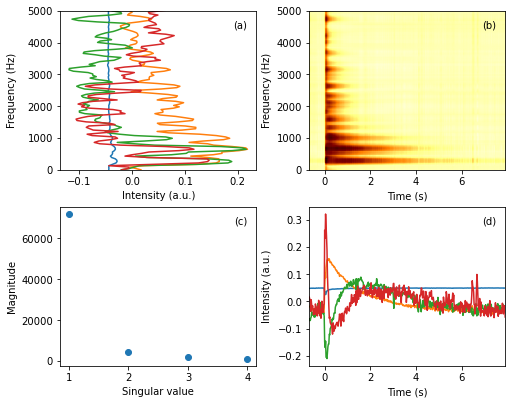

In [17]:
# Build the subplot layout
# %matplotlib notebook  # Uncomment for older jupyter notebooks (not jupyter lab)
fig = plt.figure(constrained_layout=True, figsize=(7, 5.5))
ax_u = fig.add_subplot(2, 2, 1)  # Top left, spectral slices
ax_s = fig.add_subplot(2, 2, 3)  # Bottom left, singular values
ax_v = fig.add_subplot(2, 2, 4)  # Bottom right, temporal slices
# Top right, spectrogram with axes linked to spectral and temporal slice panels
ax_img = fig.add_subplot(2, 2, 2, sharex=ax_v, sharey=ax_u)

# Spectral components (U matrix) panel
ax_u.plot(U, spec_f) 
ax_u.set_ylim(freq_range)
ax_u.set_xlabel("Intensity (a.u.)")
ax_u.set_ylabel("Frequency (Hz)")
ax_u.add_artist(AnchoredText("(a)", loc="upper right", frameon=False))

# Compressed spectrogram image panel
ax_img.imshow(spec_compressed, aspect="auto", origin="lower", extent=(spec_t[0], spec_t[-1], spec_f[0], spec_f[-1]), cmap="afmhot_r", rasterized=True)
ax_img.set_xlabel("Time (s)")
ax_img.set_ylabel("Frequency (Hz)")
ax_img.add_artist(AnchoredText("(b)", loc="upper right", frameon=False))

# Singular values (s vector) panel
s_x = np.arange(1, s.shape[0] + 1)  # x-coordinates for singular values
ax_s.scatter(s_x, s)
ax_s.set_xlabel("Singular value")
ax_s.set_ylabel("Magnitude")
ax_s.add_artist(AnchoredText("(c)", loc="upper right", frameon=False))

# Time components (V matrix) panel
ax_v.plot(spec_t, V.T)
ax_v.set_xlabel("Time (s)")
ax_v.set_ylabel("Intensity (a.u.)")
ax_v.add_artist(AnchoredText("(d)", loc="upper right", frameon=False))

fig.align_labels()
fig.show()

This is a pretty good start.
Note how the pan and zoom follows each of the three upper-right panels.

It's probably a good time to point out a couple of tricks we've been using to display the spectrogram with `imshow()`:
  - When selecting an appropriate [colour map](https://matplotlib.org/stable/gallery/color/colormap_reference.html) to give to `cmap=`, note that appending `_r` to any colour map name reverses the sequence.
    We are doing that here for the `afmhot` colour map so that the zero values blend better with the white background of the paper or screen.
  - Passing `rasterized=True` generates the image as pixel data, which is often smaller in size and faster to render in PDF readers than the vector data, with minmal loss in quality (more info in [this demo](https://matplotlib.org/stable/gallery/misc/rasterization_demo.html)).
  - The use of `imshow()` with the `extent=()` parameter is fast and efficient, but only works with data on a regular grid.
    For data on irregular grids, interpolation on to a grid, or the use of `matplotlib.pcolormesh()` are required.

Here's a list of improvements we can make to the plot:
  - Use some line colours other than the defaults.
  - The upper-right spectrogram panel axes are linked to the panels left and below.
    It would be nice to move some of the axes labels to the top and right to emphasise this.
  - Some minor ticks on the axes might be useful in places.
  - The singular values scatter plot is only a single colour.
    We really want the colours of the markers match the lines they are associated with.
    A line to guide the eye to the trend in singular values would be nice too.
  - Having non-integer axis tick labels for the singular values doesn't really make sense.
  
We'll duplicate the plotting code from the cell above and add in our tweaks.

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


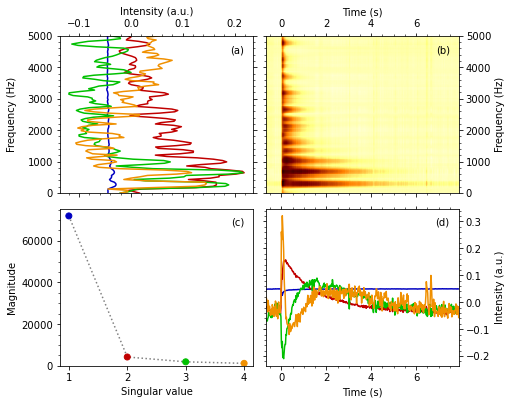

In [18]:
# Set a new default colour cycle for plots by generating a new property cycler
# solid, dotted, dashdot, dashed
linestyles = ["-", ":", "-.", "--"]
# HTML colour notation, blue, red, green, orange, cyan, magenta, black
linecolours = ["#0000c0", "#c00000", "#00c000", "#f09000", "#00c0c0", "#c000c0", "#000000"]
# Multiplying the cycles like this gives all colours solid, then all colours dotted etc
plt.rc('axes', prop_cycle=plt.rcsetup.cycler(linestyle=linestyles) * plt.rcsetup.cycler(color=linecolours))

# Make subplots, a bit manual so we can link some selected axes
fig = plt.figure(constrained_layout=True, figsize=(7, 5.5))
ax_u = fig.add_subplot(2, 2, 1)
ax_s = fig.add_subplot(2, 2, 3)
ax_v = fig.add_subplot(2, 2, 4)
ax_img = fig.add_subplot(2, 2, 2, sharex=ax_v, sharey=ax_u)

# Spectral components (U matrix) panel
lines_u = ax_u.plot(U, spec_f)  # Keeping a reference to this set of lines for use later...
ax_u.set_ylim(freq_range)
# tick_params modifies the axis ticks and tick labels, move to above the panel
ax_u.tick_params(axis="both", which="both", top=True, labeltop=True, labelbottom=False, right=True)
# Add minor tick marks to this panel
ax_u.minorticks_on()
# Move the axis label to above the plot
ax_u.xaxis.set_label_position("top")
ax_u.set_xlabel("Intensity (a.u.)")
ax_u.set_ylabel("Frequency (Hz)")
ax_u.add_artist(AnchoredText("(a)", loc="upper right", frameon=False))

# Compressed spectrogram image panel
ax_img.imshow(spec_compressed, aspect="auto", origin="lower", extent=(spec_t[0], spec_t[-1], spec_f[0], spec_f[-1]), cmap="afmhot_r", rasterized=True)
# Move tick labels to above and right of plot
ax_img.tick_params(axis="both", which="both", left=True, right=True, labelleft=False, labelright=True, top=True, bottom=True, labeltop=True, labelbottom=False)
# Add minor tick labels to this panel
ax_img.minorticks_on()
# Move axes labels to above and right of plot
ax_img.xaxis.set_label_position("top")
ax_img.yaxis.set_label_position("right")
ax_img.set_xlabel("Time (s)")
ax_img.set_ylabel("Frequency (Hz)")
ax_img.add_artist(AnchoredText("(b)", loc="upper right", frameon=False))

# Singular values (s vector) panel
s_x = np.arange(1, s.shape[0] + 1)  # x-coordinates for singular values
# Put faint line behind the scatter points to guide the eye
ax_s.plot(s_x, s, color="grey", linestyle="dotted", zorder=0.5)
# Copy marker colours from the earlier line plot
ax_s.scatter(s_x, s, c=[l.get_color() for l in lines_u])
# Use an IndexLocator for integer-only tick positions and labels
ax_s.xaxis.set_major_locator(IndexLocator(1, 0))
# Add minor tick labels, but only to the y-axis
ax_s.tick_params(axis="x", which="minor", bottom=False)
ax_s.minorticks_on()
ax_s.set_xlabel("Singular value")
ax_s.set_ylabel("Magnitude")
# Start y-axis at zero for better perspective on singular values
ax_s.set_ylim(0, None)
ax_s.add_artist(AnchoredText("(c)", loc="upper right", frameon=False))

# Time components (V matrix) panel
ax_v.plot(spec_t, V.T)
# Move tick labels to right of panel
ax_v.tick_params(axis="both", which="both", top=True, right=True, labelleft=False, labelright=True)
# Add minor tick labels to this plot
ax_v.minorticks_on()
# Move axis label to right of panel
ax_v.yaxis.set_label_position("right")
ax_v.set_xlabel("Time (s)")
ax_v.set_ylabel("Intensity (a.u.)")
#ax_v.set_xlim(spec_t[0], spec_t[-1])
ax_v.add_artist(AnchoredText("(d)", loc="upper right", frameon=False))

fig.align_labels()
fig.show()

Once the plot is right, save it out to an image file.

A variety of image formats are supported:
- `.pdf` is recommended for general viewing or using in LaTex documents.
  As it's a vector format, the file size is usually very small, and there is no loss of quality (infinite zoom, crisp text).
- `.svg` is scalable vector graphics, and is a good choice if the plot is going to be edited in another piece of software such as Inkscape, Illustrator, GIMP, Photoshop etc.
  Inkscape is free and can save out to different formats.
- `.png` is a raster image format, and is useful for situations where PDF is not supported.
  As a raster image it will be about 10x the file size of PDF, with quality dependent on the DPI parameter.

In [19]:
# PDF, for general viewing or inserting in LaTex documents
fig.savefig("svd_analysis_4up.pdf")

# SVG, for editing in other graphics software
fig.savefig("svd_analysis_4up.svg")

# PNG, for situations where PDF is not supported
fig.savefig("svd_analysis_4up.png", dpi=600)

## Saving Data to Disk

There's a huge number of formats for storing data to disk.
The choice depends on a number of factors such as size, type, or compatibility with other software.
Formats will generally fall under two categories:
- Text, eg. `.txt`, `.csv`, `.tsv`
  - Wide compatibility, human readable, but inefficient, slow, limited.
- Binary, eg. `.wav`, `.png`, `.avi`, any number of `.dat` formats...
  - Efficient, fast, versatile, but uncertain compatibility.
  
We will look at saving to the popular comma-separated values `.csv` text format, and investigate using our own "proprietory" binary file format.

### Comma-separated Values

A `.csv` file contains a table of numerical or text data, with columns separated by a comma, and rows separated by new lines.
The results from the fits we did above are small and well suited to saving to a text format such as CSV.
We can generate the text output manually.

In [20]:
# Build up a string of CSV data using the fit results from earlier
# We make good use of python's f-strings and list iteration here for some one-liner magic

# Make some column headers from the parameter names
csv = '"Frequency", ' + ", ".join([f'"{p}", "{p}_stderr"' for p in fits[0][1].params]) + "\n"

# Loop through each frequency fit result we stored earlier
for f, r in fits:
    # Generate the text for the row
    csv += f"{f}, " + ", ".join([f"{p.value}, {p.stderr}" for p in r.params.values()]) + "\n"

print(csv)

# Generate a date and time stamp string to help name the data file
# Formatting with year-to-second means filesystem sort order will make sense
timestamp = time.strftime("%y%m%d-%H%M%S", time.localtime())

# Save to disk
with open(f"{timestamp}-fit_parameters.csv", "w") as f:
    f.write(csv)

"Frequency", "A_bg", "A_bg_stderr", "t_0", "t_0_stderr", "A_0", "A_0_stderr", "k", "k_stderr"
286, -154.6127315603064, 0, -0.003254273116074069, 445.02809322384115, 129.98523106470353, 8128.379950620593, 18.263447030718243, 0.19173715204437125
657, -154.61273156030637, 0, -0.0010618613816605615, 1767.6141676804375, 152.30945511141275, 51512.078184675134, 29.142088601313873, 0.41399619027057166
1000, -156.7457913547365, 0, -0.023468122302721217, 26722.578071127282, 139.1506857492382, 1070016.6820434327, 40.03719706185501, 0.6981227879965043



For data in 1D or 2D numpy arrays, it is easy to dump the data out to a CSV with the `savetxt()` function.
We can save the spectrogram out in one line of code, but we need to stick the axes labels on if we also want them saved in the file.

In [21]:
# Allocate an array big enough for the spectrogram, plus axes labels
csv_array = np.zeros((spec_db.shape[0] + 1, spec_db.shape[1] + 1))
# Place time labels on first row
csv_array[0,1:] = spec_t
# Place frequency labels on first column
csv_array[1:,0] = spec_f
# Place spectrogram
csv_array[1:,1:] = spec_db
# Now it's ready to save to disk
np.savetxt(f"{timestamp}-spectrogram.csv", csv_array, delimiter=",", fmt="%g")

### Binary Data File

For data that is "big", but not "too big" (it can still fit in the computer's RAM), then numpy's `.npz` format can be a good choice.
It is a compressed archive of many numpy arrays, but can also store arbitrary data.
We can literally just stuff anything and everything into a single file.

In [22]:
# It's a good idea to store some metadata (data about the data) as well
metadata = {
    "name": "An Example",
    "time": time.localtime(),
    "note": "This is an .npz file stuffed full of data."
}

np.savez_compressed(f"{timestamp}-all_the_things.npz",
                    data_raw=data_raw,  # The raw wave data
                    t=t,                # Raw data time axis
                    spec_db=spec_db,    # Spectrogram
                    spec_t=spec_t,      # Spectrogram time axis
                    spec_f=spec_f,      # Spectrogram frequency axis
                    fits=fits,          # Every bit of information about the fits we did
                    metadata=metadata   # Our metadata dictionary we made above
                   )

The downside with this format is that other software won't know how to read it, and code needs to be written specifically to read the data back again.

In [23]:
# The allow_pickle=True is needed since we have stored arbitrary data inside the file
filedata = np.load(f"{timestamp}-all_the_things.npz", allow_pickle=True)

print("The .npz file contains:")
for k, v in filedata.items():
    print(f"  {k}, {v.shape}, {v.dtype}")

print(f"\nThe metadata dictionary is: {filedata['metadata']}")

print(f"\nIt has fit data for the frequencies: {filedata['fits'][:,0]}")

The .npz file contains:
  data_raw, (380567,), float64
  t, (380567,), float64
  spec_db, (513, 424), float64
  spec_t, (424,), float64
  spec_f, (513,), float64
  fits, (3, 2), object
  metadata, (), object

The metadata dictionary is: {'name': 'An Example', 'time': time.struct_time(tm_year=2022, tm_mon=5, tm_mday=19, tm_hour=15, tm_min=53, tm_sec=5, tm_wday=3, tm_yday=139, tm_isdst=0), 'note': 'This is an .npz file stuffed full of data.'}

It has fit data for the frequencies: [286 657 1000]
